## Large-scale benchmarking for system identification methods
Written by Lanyue Zhang and Alan Kaptanoglu

In this notebook, we illustrate how to design a statistically robust benchmark for new innovations in system identification. To illustrate how this benchmark can be utilized, we perform the largest comparison to date of four popular algorithms (+ the weak formulation) for solving the sparse identification of nonlinear dynamics (SINDy) optimization. 

In addition, we investigate how Pareto-optimal models generated from sparse system identification methods depend on the dynamical properties of the equations, finding to leading order that the performance of these methods is independent of the dynamical properties of these equations, including the amount of chaos, scale separation, degree of nonlinearity, and, surprisingly, the syntactic complexity.
 
We will use the dysts database, containingn over 100 chaotic systems. We will investigate a subset of the systems that are polynomially nonlinear, with highest polynomial degree <= 4. All of the following 70 systems are bounded and exhibit strange attractors.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
from dysts.equation_utils import *
import time
from utils import *

import pysindy as ps

# Chaotic System Initialization

This experiment include 70 chaotic, polynomially nonlinear systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [2]:
t1 = time.time()

# Arneodo does not have the Lyapunov spectrum calculated so omit it.
# HindmarshRose and AtmosphericRegime seem to be poorly sampled
# by the dt and dominant time scales used in the database, so we omit them.
systems_list = [
                "Aizawa", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "Hadley",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices"
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
# Get training and testing trajectories for all the experimental systems 
n = 1000  # Trajectories with 1000 points
pts_per_period = 100  # sample them with 100 points per period
n_trajectories = 5  # generate 5 trajectories starting from different initial conditions on the attractor
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list, all_properties, 
    n=n, pts_per_period=pts_per_period,
    random_bump=False,  # optionally start with initial conditions pushed slightly off the attractor
    include_transients=False,  # optionally do high-resolution sampling at rate proportional to the dt parameter 
    n_trajectories=n_trajectories
)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
2 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
3 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
4 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
5 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
6 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
7 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
8 GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
9 GuckenheimerHolmes(name='GuckenheimerHolmes', params={'a': 0.4, 'b': 20.25, 'c': 3, 'd': 1.6, 'e': 1.7, 'f': 0.44}, random_

# Calculate the true coefficients
The dysts database has functionality to read in all the dysts database functions defining the systems of ODEs, and extracts all the coefficients. We can use this to make a big matrix representing all the true coefficients in all the dynamical systems, which can be used to judge the quality of our system identification results later.

In [3]:
num_attractors = len(systems_list)

# Calculate some dynamical properties
lyap_list = []
dimension_list = []
param_list = []

# Calculate various definitions of scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])
    
    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(all_properties[system]['period'] / all_properties[system]['dt'])


# Get the true coefficients for each system
true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)

# Whether to use the weak formulation of SINDy or not
weak_form = False

# Need to reorder the coefficients if using the weak form to compare with analytic,
# because weak formulation of the SINDy library is in a different order than the
# PolynomialLibrary with degree = 4
if weak_form:
    # reordering to use if system is 3D
    reorder1 = np.array([ 0,  1,  2,  3,  4,  7,  9,  5,  6,  8, 10, 16, 19, 11, 12, 17, 13,
           15, 18, 14, 20, 30, 34, 21, 22, 31, 26, 29, 33, 23, 25, 32, 27, 28,
           24], dtype=int)
    
    # reordering to use if system is 4D
    reorder2 = np.array([ 0,  1,  2,  3,  4,  5,  9, 12, 14,  6,  7,  8, 10, 11, 13, 15, 25,
           31, 34, 16, 17, 18, 26, 27, 32, 19, 22, 24, 28, 30, 33, 20, 21, 23,
           29, 35, 55, 65, 69, 36, 37, 38, 56, 57, 66, 45, 51, 54, 61, 64, 68,
           39, 42, 44, 58, 60, 67, 46, 47, 52, 62, 48, 50, 53, 63, 40, 41, 43,
           59, 49], dtype=int)

    for i, system in enumerate(systems_list):
        if dimension_list[i] == 3:
            true_coefficients[i] = true_coefficients[i][:, reorder1]
        else:
            true_coefficients[i] = true_coefficients[i][:, reorder2]

# Compute all the different nonlinear terms from the true coefficients
nonlinearities = nonlinear_terms_from_coefficients(true_coefficients)

# Compute various dynamical properties 
count = 0
for i, system in enumerate(systems_list):
    linear_coefs = true_coefficients[i][:, :dimension_list[i]] 
    max_linear = np.max(abs(linear_coefs))
    min_linear = np.min(abs(linear_coefs[linear_coefs != 0.0]))
    linear_scale_list.append(max_linear / min_linear)
    sorted_spectrum = np.sort((np.array(all_properties[system]['lyapunov_spectrum_estimated'])))
    lambda_max = sorted_spectrum[-1]
    lambda_min = sorted_spectrum[0]
    if np.all(np.array(all_properties[system]['lyapunov_spectrum_estimated'][0:2]) > 0.0):
        count += 1
    scale_list.append(lambda_max / lambda_min)

print('Number of hyper-chaotic (at least two positive Lyapunov exponents) systems = ', count)

# Lastly, compute the syntactic complexity of all the dynamical system equations,
# as measured by the mean-equation description length (MEDL). More informationn 
# can be found in the AI Feynman 2.0 paper
medl_list = compute_medl(systems_list, param_list)

Number of hyper-chaotic (at least two positive Lyapunov exponents) systems =  51


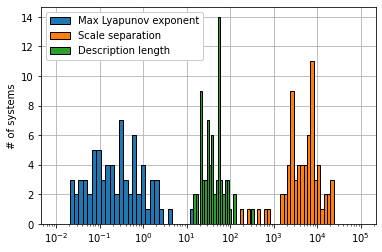

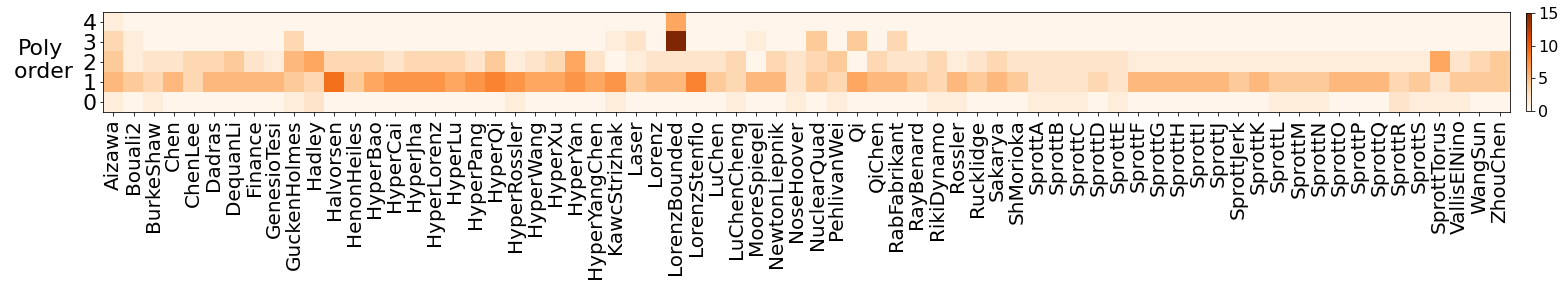

In [4]:
from matplotlib.colors import LogNorm

# Shorten some of the dynamical system names to make nicer plots
systems_list_cleaned = []
for i, system in enumerate(systems_list):
    if system == "GuckenheimerHolmes":
        systems_list_cleaned.append("GuckenHolmes")
    elif system == "NuclearQuadrupole":
        systems_list_cleaned.append("NuclearQuad")
    elif system == "RabinovichFabrikant":
        systems_list_cleaned.append("RabFabrikant")
    elif system == "KawczynskiStrizhak":
        systems_list_cleaned.append("KawcStrizhak")
    elif system == "RikitakeDynamo":
        systems_list_cleaned.append("RikiDynamo")
    elif system == "ShimizuMorioka":
        systems_list_cleaned.append("ShMorioka")
    elif system == "HindmarshRose":
        systems_list_cleaned.append("Hindmarsh")
    elif system == "RayleighBenard":
        systems_list_cleaned.append("RayBenard")
    else:
        systems_list_cleaned.append(system)
    
# Make two summary plots of all the dynamical system properties
plt.figure()
medl_levels = np.logspace(1, 3, 40)
lyap_levels = np.logspace(-2, 2, 40)
scale_levels = np.logspace(2, 5, 40)

plt.hist(lyap_list, bins=lyap_levels, ec='k')
plt.hist(scale_list_avg, bins=scale_levels, ec='k')
plt.hist(medl_list, bins=medl_levels, ec='k')
plt.xlabel('')
plt.ylabel('# of systems')
plt.legend(['Max Lyapunov exponent', 'Scale separation', 'Description length'],
           framealpha=1.0)
plt.xscale('log')
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True)

plt.figure(figsize=(30, 6))
plt.imshow(nonlinearities.T, aspect='equal', origin='lower', cmap='Oranges')
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=20)
ax = plt.gca()
plt.xlim(-0.5, num_attractors - 0.5)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(np.arange(5), fontsize=22)
plt.colorbar(shrink=0.3, pad=0.01).ax.tick_params(labelsize=16)
plt.ylabel('Poly\n order', rotation=0, fontsize=22)
ax.yaxis.set_label_coords(-0.045, 0.3)

## Trajectory Visualization
Visualizing the training and testing trajectories helps us verify if the time series data is coming from the strange attractors or from transients in the evolution.

Took  1.7103805541992188  seconds to plot the systems


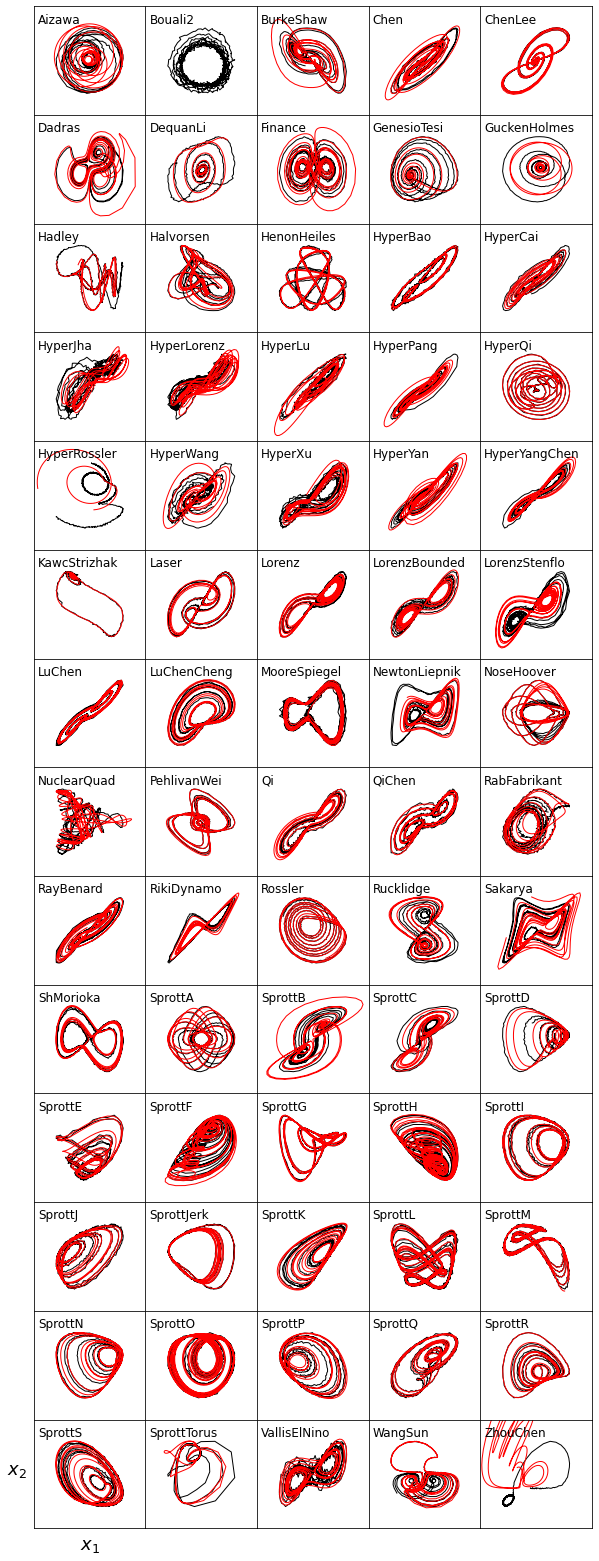

In [5]:
t1 = time.time()

# add some Gaussian noise
noise_level = 2.0

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
plt.figure(figsize=(num_cols * 2, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.0) 

for i, attractor_name in enumerate(systems_list):
    
    x_train = np.copy(all_sols_train[attractor_name][0])
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    x_train += np.random.normal(0, rmse / 100.0 * noise_level, x_train.shape)
    x_test = all_sols_test[attractor_name][0]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=1)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=1)
    ax = plt.gca()
    plt.yticks([])
    plt.xticks([])
    xmax = np.max(x_train[:, 0])
    xmin = np.min(x_train[:, 0])
    ymax = np.max(x_train[:, 1])
    ymin = np.min(x_train[:, 1])
    facx = (xmax - xmin) / 3
    facy = (ymax - ymin) / 3
    plt.xlim(xmin - facx, xmax + facx)
    plt.ylim(ymin - facy, ymax + facy)
    plt.text(0.035, 0.85, systems_list_cleaned[i], transform=ax.transAxes, fontsize=12)
    if i == 65:
        plt.xlabel(r'$x_1$', fontsize=18)
        plt.ylabel(r'$x_2$', fontsize=18, rotation=0, )
        ax.yaxis.set_label_coords(-0.15,0.45)
            
plt.savefig('trajectories.pdf')
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')
plt.show()

# Hyperparameter scans using the AIC metric
Below, we perform hyperparameter scans where the best model at each iteration is the one that minimizes the finite-sampled-corrected AIC on a test trajectory (see Mangan, Niall M., et al. "Model selection for dynamical systems via sparse regression and information criteria." Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 473.2204 (2017): 20170009.). Unlike previous work, at every value of the hyperparameter, we generate $n_\text{models}$ models, and take as our metric the average AIC over the 10 models. The default is to scan 300 values of the hyperparameter, so in total we compute 300 x $n_\text{models}$ x 70 = 210,000 models!

In [6]:
weak_form=True
algorithm="STLSQ"
strong_rmse=False
t1 = time.time()

# Note, defaults to using the AIC to decide the Pareto-optimal model
n_models = 10
(xdot_rmse_errors, xdot_coef_errors, AIC, x_dot_tests, x_dot_test_preds,
predicted_coefficients, best_threshold_values, models, condition_numbers) = Pareto_scan_ensembling(
    systems_list, dimension_list, true_coefficients, 
    all_sols_train, all_t_train, all_sols_test, all_t_test, 
    normalize_columns=False,  # whether to normalize the SINDy matrix
    noise_level=noise_level,  # amount of noise to add to the training data
    n_models=n_models,  # number of models to train using EnsemblingOptimizer functionality
    n_subset=int(0.5 * len(all_t_train['HyperBao'][0])),  # subsample 50% of the training data for each model
    replace=False,  # Do the subsampling without replacement
    weak_form=weak_form,  # use the weak form or not
    algorithm=algorithm, # optimization algorithm
    strong_rmse=strong_rmse, # use the strong rmse with the weak form or not
)
            
t2 = time.time()
print('Total time to compute = ', t2 - t1, ' seconds')
print('Condition numbers = ', condition_numbers)

0  /  70 , System =  Aizawa
1  /  70 , System =  Bouali2
2  /  70 , System =  BurkeShaw
3  /  70 , System =  Chen
4  /  70 , System =  ChenLee
5  /  70 , System =  Dadras
6  /  70 , System =  DequanLi
7  /  70 , System =  Finance
8  /  70 , System =  GenesioTesi
9  /  70 , System =  GuckenheimerHolmes
10  /  70 , System =  Hadley
11  /  70 , System =  Halvorsen
12  /  70 , System =  HenonHeiles
13  /  70 , System =  HyperBao
14  /  70 , System =  HyperCai
15  /  70 , System =  HyperJha
16  /  70 , System =  HyperLorenz
17  /  70 , System =  HyperLu
18  /  70 , System =  HyperPang
19  /  70 , System =  HyperQi
20  /  70 , System =  HyperRossler
21  /  70 , System =  HyperWang
22  /  70 , System =  HyperXu
23  /  70 , System =  HyperYan
24  /  70 , System =  HyperYangChen
25  /  70 , System =  KawczynskiStrizhak
26  /  70 , System =  Laser
27  /  70 , System =  Lorenz
28  /  70 , System =  LorenzBounded
29  /  70 , System =  LorenzStenflo
30  /  70 , System =  LuChen
31  /  70 , System =

### Normalized Error
Below, we compute the total normalized coefficient errors, RMSE errors on the $\dot{\mathbf X}$ testing trajectories, and best thresholds for each system. For the weak form, some sorting and additional metrics are computed. 

In [8]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
best_thresholds = np.zeros(num_attractors)
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    best_thresholds[i] = best_threshold_values[attractor_name][0]

if weak_form:
    rmse_error_strong = {}

    for system in systems_list:
        rmse_error_strong[system] = list()

    reorder1 = np.array([ 0,  1,  2,  3,  4,  7,  8,  5,  9,  6, 10, 13, 14, 16, 19, 17, 11,
           15, 18, 12, 20, 23, 24, 29, 34, 30, 26, 32, 33, 27, 21, 25, 31, 28,
           22], dtype=int)
    reorder2 = np.array([ 0,  1,  2,  3,  4,  5,  9, 10, 11,  6, 12, 13,  7, 14,  8, 15, 19,
           20, 21, 25, 31, 32, 26, 33, 27, 16, 22, 23, 28, 34, 29, 17, 24, 30,
           18, 35, 39, 40, 41, 51, 65, 66, 52, 67, 53, 45, 57, 58, 61, 69, 62,
           46, 59, 63, 47, 36, 42, 43, 54, 68, 55, 48, 60, 64, 49, 37, 44, 56,
           50, 38], dtype=int)
    
    # Compute the "strong" RMSE errors using a non-weak model, since otherwise
    # the RMSE from the weak model is computed from the subdomains. This is 
    # normally fine, but we would like to compare the same RMSE error between the 
    # traditional and weak SINDy methods. 
    models_strong = []
    for i, attractor_name in enumerate(systems_list):
        x_test_list = []
        t_test_list = []
        for j in range(n_trajectories):
            x_test_list.append(all_sols_test[attractor_name][j])
            t_test_list.append(all_t_test[attractor_name][j])
        poly_lib = ps.PolynomialLibrary(degree=4)
        if dimension_list[i] == 3:
            feature_names = ["x", "y", "z"]
        else:
            feature_names = ["x", "y", "z", "w"]
        optimizer = ps.STLSQ(
            threshold=0.0,
            alpha=1e-5,
            max_iter=100,
            normalize_columns=False,
            ridge_kw={"tol": 1e-10},
        )
        model = ps.SINDy(
            feature_library=poly_lib,
            optimizer=optimizer,
            feature_names=feature_names,
        )
        model.fit(np.zeros(all_sols_train[attractor_name][0].shape))

        rmses=[]
        for coef_temp in predicted_coefficients[attractor_name][0]:
            if dimension_list[i] == 3:
                model.optimizer.coef_ = coef_temp[:, reorder1]
            else:
                model.optimizer.coef_ = coef_temp[:, reorder2]
            model.print()
            models_strong.append(model)
            x_dot_test = model.differentiate(x_test_list, t=t_test_list, multiple_trajectories=True)
            x_dot_test_pred = model.predict(x_test_list, multiple_trajectories=True)
            rmses=rmses+[normalized_RMSE(
                np.array(x_dot_test).reshape(n_trajectories * n, dimension_list[i]),
                np.array(x_dot_test_pred).reshape(n_trajectories * n, dimension_list[i]),
                )]
        rmse_error_strong[attractor_name].append(np.mean(rmses))

(x)' = -0.713 x + -3.503 y + 0.160 x y + 1.003 x z + 0.165 x^3 + -0.465 x y^2 + 0.158 x y z + -0.173 x y^3 + -0.135 x y z^2
(y)' = 3.502 x + -0.700 y + -0.374 x^2 + 0.406 x y + 0.384 y^2 + 1.000 y z + -0.377 x^2 y + 0.613 x y z + 0.116 y^3 + -0.827 x^3 y + 0.763 x^2 y^2 + 0.330 x^2 y z + 0.143 x^2 z^2 + -0.412 x y z^2 + -0.262 y^4 + -0.092 y^3 z + -0.146 y^2 z^2
(z)' = 0.606 1 + 0.940 z + -0.852 x^2 + -1.173 y^2 + -0.730 x^2 z + 0.304 x y^2 + 0.242 y^2 z + -0.332 z^3 + 0.580 x^3 y + 0.096 x^2 y z + 0.316 x y^3
(x)' = -0.704 x + -3.503 y + 0.991 x z + -0.216 x y z + 0.170 x^3 z + 0.343 x^2 y z + 0.128 x y^3 + -0.486 x y^2 z + 0.113 x y z^2 + -0.114 y^3 z
(y)' = 3.504 x + -0.699 y + 0.278 x y + 1.005 y z + 0.424 x y z + -0.355 x^3 y + -0.301 x y z^2
(z)' = 0.600 1 + 0.949 z + -1.037 x^2 + -0.964 y^2 + -0.183 x^2 z + -0.316 y^2 z + -0.333 z^3 + 0.271 x^3 y + 0.104 x^3 z + -0.325 x y^3
(x)' = -0.706 x + -3.501 y + 0.996 x z + 0.164 x^3 + -0.474 x y^2 + 0.361 x^2 y z + -0.119 y^3 z
(y)' = 3

(x)' = 1.222 1 + -39.992 x + 40.067 y + 0.160 x z
(y)' = -1.972 1 + 54.805 x + 19.958 y + -0.997 x z
(z)' = -2.346 1 + 0.157 x + -0.100 y + 1.884 z + -0.649 x^2 + 0.999 x y
(x)' = 0.509 1 + -39.975 x + 40.072 y + 0.160 x z
(y)' = -4.049 1 + 54.933 x + 19.948 y + 0.023 z + -0.998 x z
(z)' = 2.425 1 + 0.207 x + -0.130 y + 1.856 z + -0.649 x^2 + 0.998 x y
(x)' = 1.546 1 + -39.967 x + 40.080 y + 0.160 x z
(y)' = -1.165 1 + 54.836 x + 19.934 y + -0.997 x z
(z)' = -4.480 1 + 0.226 x + -0.111 y + 1.895 z + -0.649 x^2 + 0.999 x y
(x)' = 1.886 1 + -40.076 x + 40.084 y + 0.161 x z
(y)' = -3.140 1 + 54.869 x + 19.933 y + -0.998 x z
(z)' = -3.370 1 + 0.237 x + -0.111 y + 1.894 z + -0.649 x^2 + 0.999 x y
(x)' = 2.091 1 + -40.009 x + 40.085 y + 0.160 x z
(y)' = -10.172 1 + 54.895 x + 19.965 y + 0.056 z + -0.998 x z
(z)' = -6.829 1 + 0.238 x + -0.120 y + 1.911 z + -0.649 x^2 + 1.000 x y
(x)' = 2.080 1 + -40.050 x + 40.053 y + 0.161 x z
(y)' = -2.091 1 + 54.966 x + 19.911 y + -0.998 x z
(z)' = -4.401 

(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.001 x + -2.003 x y
(w)' = -1.000 y + -1.000 x^2 + 0.998 y^2
(x)' = 1.000 z
(y)' = 0.999 w
(z)' = -1.000 x + -2.002 x y
(w)' = -1.000 y + -0.999 x^2 + 0.999 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.000 x + -2.001 x y
(w)' = -1.000 y + -1.000 x^2 + 0.999 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.000 x + -2.003 x y
(w)' = -1.000 y + -1.000 x^2 + 0.999 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.000 x + -2.002 x y
(w)' = -1.000 y + -1.000 x^2 + 0.999 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.000 x + -2.003 x y
(w)' = -1.000 y + -0.999 x^2 + 0.998 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.001 x + -2.004 x y
(w)' = -1.000 y + -1.000 x^2 + 0.999 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.000 x + -2.003 x y
(w)' = -1.000 y + -1.000 x^2 + 0.998 y^2
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -1.000 x + -2.002 x y
(w)' = -0.999 y + -1.000 x^2 + 0.998 y^2
(x)' = -35.981 x + 35.992 y + 0.996 w
(y)' = -0.107 1 + -0.180 x + 20.110 y + -0.997 x z
(z)' = -0.3

(x)' = -36.113 x + 36.124 y
(y)' = 1.451 x + 19.407 y + 1.043 w + -1.041 x z
(z)' = 0.359 1 + -3.017 z + 1.001 x y
(w)' = -2.018 x + -1.983 y
(x)' = -6.188 1 + -36.167 x + 36.176 y + 0.385 z + -0.288 x^2 + 0.264 x y
(y)' = 1.991 x + 19.188 y + 1.051 w + -1.057 x z
(z)' = 0.220 1 + -3.012 z + 1.001 x y
(w)' = -2.020 x + -1.982 y
(x)' = -36.007 x + 35.988 y
(y)' = 1.883 x + 19.188 y + 1.049 w + -1.052 x z
(z)' = 0.230 1 + -3.011 z + 1.001 x y
(w)' = -2.023 x + -1.980 y
(x)' = -36.015 x + 36.028 y
(y)' = 20.038 y + 1.001 w + -1.001 x z
(z)' = 0.315 1 + -3.018 z + 1.002 x y
(w)' = -2.018 x + -1.984 y
(x)' = -5.515 1 + -36.257 x + 36.251 y + 0.318 z + -0.234 x^2 + 0.222 x y
(y)' = 1.869 x + 19.192 y + 1.055 w + -1.051 x z
(z)' = -2.996 z + 0.999 x y
(w)' = -2.031 x + -1.972 y
(x)' = -36.154 x + 36.170 y
(y)' = 1.820 x + 19.270 y + 1.050 w + -1.052 x z
(z)' = -3.000 z + 1.000 x y
(w)' = -3.950 y
(x)' = -36.066 x + 36.071 y
(y)' = 1.785 x + 19.251 y + 1.048 w + -1.049 x z
(z)' = 0.157 1 + -3.

(x)' = 0.238 1 + -29.492 x + 29.459 y
(y)' = 35.022 x + 1.003 w + -1.000 x z
(z)' = -0.542 1 + -2.983 z + 1.001 x y
(w)' = -8.007 x
(x)' = -29.501 x + 29.455 y
(y)' = 34.730 x + 0.121 y + 1.001 w + -0.995 x z
(z)' = -0.762 1 + -2.981 z + 1.002 x y
(w)' = -8.011 x
(x)' = 0.449 1 + -29.531 x + 29.490 y
(y)' = 34.785 x + 0.117 y + 1.001 w + -0.997 x z
(z)' = -1.030 1 + -2.971 z + 1.001 x y
(w)' = 0.103 1 + -8.008 x
(x)' = 0.343 1 + -29.526 x + 29.495 y
(y)' = 34.511 x + 0.251 y + 0.997 w + -0.993 x z
(z)' = -0.506 1 + -2.986 z + 1.002 x y
(w)' = -8.011 x
(x)' = 0.296 1 + -29.532 x + 29.493 y
(y)' = 34.702 x + 0.159 y + 1.000 w + -0.996 x z
(z)' = -0.701 1 + -2.983 z + 1.002 x y
(w)' = -8.010 x
(x)' = 0.287 1 + -29.650 x + 29.603 y
(y)' = 34.495 x + 0.276 y + 0.994 w + -0.993 x z
(z)' = -0.501 1 + -2.991 z + 1.003 x y
(w)' = -8.012 x
(x)' = -2.867 1 + -23.126 x + 26.602 y + 0.093 z + 0.100 w + -0.098 x z
(y)' = 34.716 x + 0.153 y + 0.998 w + -0.996 x z
(z)' = -0.305 1 + -2.989 z + 1.000 x 

(x)' = -1.996 x + 1.996 y + 1.512 w
(y)' = 25.391 x + -0.913 y + -0.980 x z
(z)' = -0.695 z + 0.993 x y
(w)' = -0.442 y + -1.033 w
(x)' = -1.998 x + 1.995 y + 1.505 w
(y)' = 25.256 x + -0.893 y + -0.976 x z
(z)' = -0.695 z + 0.992 x y
(w)' = -0.996 x + -1.992 w
(x)' = 1.103 y + 3.434 w
(y)' = 25.104 x + -0.859 y + -0.972 x z
(z)' = -0.694 z + 0.992 x y
(w)' = -0.994 x + -1.989 w
(x)' = -1.994 x + 1.994 y + 1.511 w
(y)' = 25.278 x + -0.891 y + -0.977 x z
(z)' = -0.693 z + 0.990 x y
(w)' = 0.000
(x)' = -2.001 x + 1.997 y + 1.507 w
(y)' = 24.920 x + -0.839 y + -0.965 x z
(z)' = -0.693 z + 0.990 x y
(w)' = -0.996 x + -1.991 w
(x)' = -1.999 x + 1.996 y + 1.505 w
(y)' = 24.880 x + -0.835 y + -0.964 x z
(z)' = -0.694 z + 0.991 x y
(w)' = -0.455 y + -1.056 w
(x)' = -2.002 x + 1.997 y + 1.497 w
(y)' = 25.167 x + -0.877 y + -0.973 x z
(z)' = -0.694 z + 0.991 x y
(w)' = 1.762 w + -0.604 w^3
(x)' = -2.010 x + 2.002 y + 1.495 w
(y)' = 24.853 x + -0.832 y + -0.963 x z
(z)' = -0.693 z + 0.990 x y
(w)

(x)' = 1.000 y
(y)' = -1.000 x + 1.003 y z
(z)' = 1.498 1 + -0.999 y^2
(x)' = 1.000 y
(y)' = -1.000 x + 1.003 y z
(z)' = 1.499 1 + -0.999 y^2
(x)' = 1.000 y
(y)' = -1.000 x + 1.003 y z
(z)' = 1.499 1 + -0.999 y^2
(x)' = 1.000 z
(y)' = 0.999 w
(z)' = -0.997 x + 1.164 x^2 + -1.167 y^2 + -0.400 x^3 + -0.402 x y^2
(w)' = -0.995 y + -2.338 x y + -0.404 x^2 y + -0.401 y^3
(x)' = 1.000 z
(y)' = 1.000 w
(z)' = -0.997 x + 1.161 x^2 + -1.164 y^2 + -0.399 x^3 + -0.400 x y^2
(w)' = -0.998 y + -2.337 x y + -0.401 x^2 y + -0.401 y^3
(x)' = 1.000 z
(y)' = 0.999 w
(z)' = -0.995 x + 1.162 x^2 + -1.166 y^2 + -0.399 x^3 + -0.404 x y^2
(w)' = -0.999 y + -2.334 x y + -0.397 x^2 y + -0.401 y^3
(x)' = 1.000 z
(y)' = 0.999 w
(z)' = -0.998 x + 1.165 x^2 + -1.168 y^2 + -0.400 x^3 + -0.401 x y^2
(w)' = -0.996 y + -2.342 x y + -0.400 x^2 y + -0.404 y^3
(x)' = 1.000 z
(y)' = 0.999 w
(z)' = -0.998 x + 1.163 x^2 + -1.167 y^2 + -0.399 x^3 + -0.402 x y^2
(w)' = -0.996 y + -2.339 x y + -0.404 x^2 y + -0.401 y^3
(x)' = 

(x)' = 22.938 1 + 21.314 x + 15.414 y + -4.170 z + 25.366 w + -14.369 x^2 + 5.719 x y + -2.103 x z + 10.799 x w + -8.723 y^2 + -9.887 y z + 12.663 y w + -2.064 z w + -8.027 w^2 + 22.256 x^3 + -28.350 x^2 y + 4.066 x^2 z + 12.445 x^2 w + -3.436 x y^2 + -8.037 x y w + -9.912 x z w + 12.843 y^3 + -1.449 y^2 z + -3.271 y^2 w + 1.392 y z^2 + 4.006 y z w + -3.733 y w^2 + -2.590 w^3 + -1.838 x^4 + 4.987 x^3 y + -3.833 x^3 w + -4.577 x^2 y^2 + -3.022 x^2 y z + 7.832 x^2 y w + -1.113 x^2 z^2 + 1.626 x^2 w^2 + 6.603 x y^2 z + -6.833 x y^2 w + 1.149 x y z^2 + -5.009 x y w^2 + 1.053 x z^2 w + -2.007 x z w^2 + 2.743 x w^3 + 1.620 y^4 + -3.594 y^3 z + 1.359 y^3 w + -0.906 y^2 z w + 4.891 y^2 w^2 + -1.050 y z^2 w + 3.236 y z w^2 + -2.300 y w^3 + 1.132 z w^3 + -1.469 w^4
(y)' = 10.178 x + 9.870 y + -1.003 x z w
(z)' = -1.000 z + 1.000 x y w
(w)' = -22.533 w + 5.107 y^2 + 2.066 z w + -1.795 w^2 + 0.845 x^2 w + 11.389 x y w + -8.994 y^2 w + -1.741 x^2 y^2 + 2.663 x y^3 + -1.228 x y z w + -1.175 y^4 + 1.

(x)' = -1.000 y + -1.002 z
(y)' = 0.999 x + 0.199 y
(z)' = -5.572 z + 0.988 x z
(x)' = -1.000 y + -1.001 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.532 z + 0.981 x z
(x)' = -1.000 y + -1.001 z
(y)' = 1.000 x + 0.200 y
(z)' = -5.576 z + 0.988 x z
(x)' = -1.000 y + -1.001 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.522 z + 0.979 x z
(x)' = -1.000 y + -1.002 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.527 z + 0.980 x z
(x)' = -1.000 y + -1.001 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.514 z + 0.978 x z
(x)' = -1.000 y + -1.003 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.600 z + 0.993 x z
(x)' = -1.000 y + -1.001 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.539 z + 0.982 x z
(x)' = -1.000 y + -1.001 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.570 z + 0.987 x z
(x)' = -1.000 y + -1.003 z
(y)' = 1.000 x + 0.199 y
(z)' = -5.536 z + 0.981 x z
(x)' = -1.992 x + 6.659 y + -0.995 y z
(y)' = 1.000 x
(z)' = -0.995 z + 0.994 y^2
(x)' = -1.986 x + 6.648 y + -0.993 y z
(y)' = 1.000 x
(z)' = -0.994 z + 0.993 y^2
(x)' = -1.992 x + 6.672 y + -0.997 y

(x)' = 0.400 x + 1.001 z
(y)' = -1.000 y + 0.998 x z
(z)' = -1.000 x + 1.001 y
(x)' = 0.400 x + 1.001 z
(y)' = -1.002 y + 1.000 x z
(z)' = -1.000 x + 1.001 y
(x)' = 0.400 x + 1.001 z
(y)' = -1.001 y + 0.998 x z
(z)' = -0.999 x + 1.001 y
(x)' = 0.400 x + 1.001 z
(y)' = -1.000 y + 0.998 x z
(z)' = -0.999 x + 1.000 y
(x)' = 0.400 x + 1.001 z
(y)' = -1.001 y + 1.000 x z
(z)' = -1.000 x + 1.000 y
(x)' = 0.400 x + 1.001 z
(y)' = -1.000 y + 0.998 x z
(z)' = -1.000 x + 1.001 y
(x)' = 0.400 x + 1.000 z
(y)' = -1.001 y + 1.000 x z
(z)' = -1.000 x + 1.000 y
(x)' = 0.400 x + 1.000 z
(y)' = -1.002 y + 1.000 x z
(z)' = -1.000 x + 1.001 y
(x)' = 0.400 x + 1.001 z
(y)' = -1.001 y + 0.999 x z
(z)' = -1.000 x + 1.001 y
(x)' = -0.996 y + 0.995 z^2
(y)' = 1.003 x + 0.501 y
(z)' = 1.002 x + -1.000 z
(x)' = -0.993 y + 0.991 z^2
(y)' = 1.003 x + 0.501 y
(z)' = 1.001 x + -1.000 z
(x)' = -0.990 y + 0.989 z^2
(y)' = 1.002 x + 0.501 y
(z)' = 1.001 x + -1.000 z
(x)' = -0.996 y + 0.994 z^2
(y)' = 1.003 x + 0.501 y

(x)' = 1.000 y
(y)' = 1.000 z
(z)' = -0.982 x + -1.985 z + 0.981 y^2
(x)' = 1.000 y
(y)' = 1.000 z
(z)' = -0.982 x + -1.985 z + 0.981 y^2
(x)' = 1.001 y
(y)' = 1.000 z
(z)' = -0.983 x + -1.987 z + 0.983 y^2
(x)' = 1.000 y
(y)' = 1.000 z
(z)' = -0.982 x + -1.983 z + 0.981 y^2
(x)' = 1.001 y
(y)' = 1.001 z
(z)' = -0.977 x + -1.973 z + 0.977 y^2
(x)' = 1.000 y
(y)' = 1.000 z
(z)' = -0.985 x + -1.989 z + 0.984 y^2
(x)' = 1.001 y
(y)' = 1.000 z
(z)' = -0.982 x + -1.983 z + 0.982 y^2
(x)' = 1.001 y
(y)' = 1.000 z
(z)' = -0.976 x + -1.970 z + 0.976 y^2
(x)' = 1.001 y
(y)' = 1.000 z
(z)' = -0.981 x + -1.982 z + 0.980 y^2
(x)' = 1.001 y
(y)' = 1.000 z
(z)' = -0.982 x + -1.984 z + 0.982 y^2
(x)' = -1.000 z + 0.999 x y
(y)' = 1.001 x + -1.002 y
(z)' = 0.998 x + 0.299 z
(x)' = -1.001 z + 0.999 x y
(y)' = 1.001 x + -1.002 y
(z)' = 0.998 x + 0.299 z
(x)' = -1.000 z + 0.999 x y
(y)' = 1.001 x + -1.002 y
(z)' = 0.999 x + 0.299 z
(x)' = -1.000 z + 0.999 x y
(y)' = 1.001 x + -1.002 y
(z)' = 0.999 x + 0.

(x)' = 2.702 y + 1.001 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 1.000 x + 0.999 y
(x)' = 2.706 y + 1.002 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 0.999 x + 0.999 y
(x)' = 2.704 y + 1.001 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 1.000 x + 0.999 y
(x)' = 2.703 y + 1.001 z
(y)' = -0.999 x + 0.999 y^2
(z)' = 0.999 x + 0.999 y
(x)' = 2.704 y + 1.002 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 0.999 x + 0.999 y
(x)' = 2.701 y + 1.000 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 0.999 x + 0.999 y
(x)' = 2.704 y + 1.002 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 0.999 x + 0.999 y
(x)' = 2.703 y + 1.001 z
(y)' = -0.999 x + 0.999 y^2
(z)' = 0.999 x + 0.999 y
(x)' = 2.701 y + 1.001 z
(y)' = -0.998 x + 0.998 y^2
(z)' = 0.999 x + 0.998 y
(x)' = 2.706 y + 1.002 z
(y)' = -0.998 x + 0.999 y^2
(z)' = 0.999 x + 0.999 y
(x)' = -1.000 z
(y)' = 0.999 x + -0.999 y
(z)' = 3.098 x + 0.499 z + 1.000 y^2
(x)' = -1.000 z
(y)' = 0.998 x + -0.999 y
(z)' = 3.098 x + 0.500 z + 1.001 y^2
(x)' = -1.000 z
(y)' = 0.999 x + -1.000 y
(z)' = 3.099 x + 0.4

(x)' = 0.200 x + 1.001 y z
(y)' = -0.386 y + -0.723 x z + 0.211 x^2 y + -0.283 y z^2 + -0.578 x y^2 z + 0.624 x z^3
(z)' = -0.996 z + -0.997 x y
(x)' = 0.200 x + 0.999 y z
(y)' = -0.409 y + -0.770 x z + 0.239 x^2 y + -0.232 x y^2 z + 0.646 x z^3
(z)' = -1.002 z + -1.002 x y
(x)' = 0.200 x + 1.000 y z
(y)' = -0.410 y + -0.778 x z + 0.237 x^2 y + -0.214 x y^2 z + 0.619 x z^3
(z)' = -0.997 z + -0.998 x y
(x)' = 0.200 x + 1.000 y z
(y)' = -0.421 y + -1.013 x z + -0.270 x y^2 z + 0.341 x z^3
(z)' = -1.001 z + -1.001 x y
(x)' = 0.200 x + 1.000 y z
(y)' = -0.414 y + -1.039 x z
(z)' = -0.998 z + -0.998 x y
(x)' = 0.200 x + 1.000 y z
(y)' = -0.400 y + -0.759 x z + 0.257 x^2 y + 0.360 x z^3
(z)' = -0.996 z + -0.997 x y
(x)' = 0.200 x + 1.000 y z
(y)' = -0.402 y + -0.807 x z + 0.210 x^2 y + 0.289 x z^3
(z)' = -1.001 z + -1.002 x y
(x)' = 0.200 x + 1.000 y z
(y)' = -0.410 y + -1.027 x z
(z)' = -0.998 z + -1.000 x y
(x)' = 0.200 x + 1.001 y z
(y)' = -0.410 y + -0.785 x z + 0.227 x^2 y + -0.197 x y^

In [9]:
#The average Pareto-optimal strong rmse agrees with the average in strong_rmse=True case
np.array([rmse_error_strong[attractor_name][0] for attractor_name in systems_list])-avg_rmse_error

array([ 1.38777878e-17,  6.93889390e-18,  0.00000000e+00,  8.67361738e-19,
       -2.77555756e-17, -1.38777878e-17,  8.67361738e-19, -5.55111512e-17,
        2.16840434e-19, -1.30104261e-18,  0.00000000e+00,  0.00000000e+00,
        4.33680869e-19,  4.33680869e-19, -3.46944695e-18, -8.67361738e-19,
       -3.46944695e-18, -6.93889390e-18,  0.00000000e+00,  0.00000000e+00,
       -8.67361738e-18,  1.73472348e-18,  1.73472348e-18,  0.00000000e+00,
        0.00000000e+00, -2.77555756e-17,  0.00000000e+00,  0.00000000e+00,
        5.55111512e-17,  0.00000000e+00,  0.00000000e+00, -2.60208521e-18,
        0.00000000e+00,  0.00000000e+00, -1.73472348e-18,  8.67361738e-19,
       -1.73472348e-18,  0.00000000e+00, -3.46944695e-18,  6.93889390e-18,
        0.00000000e+00, -1.73472348e-18,  0.00000000e+00,  1.73472348e-18,
        0.00000000e+00,  0.00000000e+00,  3.46944695e-18, -6.93889390e-18,
       -1.73472348e-18,  0.00000000e+00, -3.46944695e-18,  0.00000000e+00,
        0.00000000e+00,  

# Plot overall performance across dynamical systems

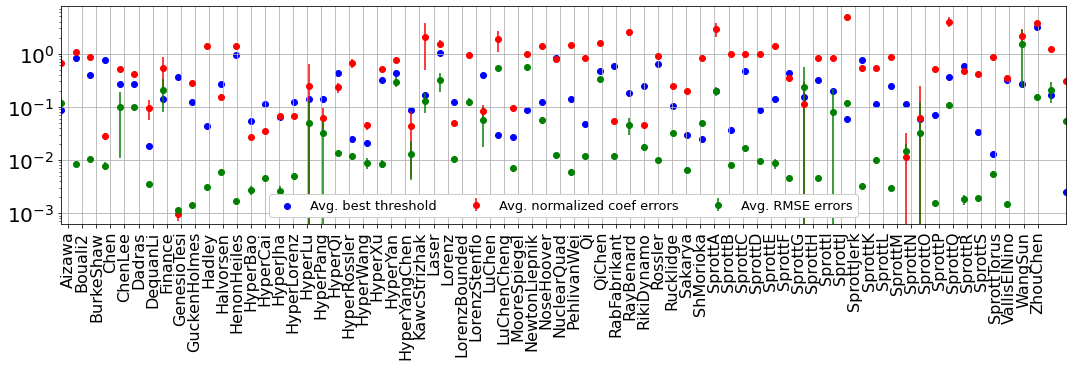

In [10]:
plt.figure(figsize=(18, 4))
    
plt.errorbar(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    np.mean(coef_avg_error, axis=-1),
    np.std(coef_avg_error, axis=-1),
    fmt="ro",
    label="Avg. normalized coef errors",
)
plt.errorbar(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    avg_rmse_error,
    std_rmse_error,
    fmt="go",
    label="Avg. RMSE errors",
)
plt.scatter(
    np.linspace(-0.5, num_attractors + 1, num_attractors), 
    best_thresholds, c="b", marker='o',
    label="Avg. best threshold"
)
plt.grid(True)
plt.yscale("log")
plt.legend(
    framealpha=1.0,
    ncol=4,
    fontsize=13,
)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-0.5, num_attractors + 1)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(fontsize=20)
plt.show()

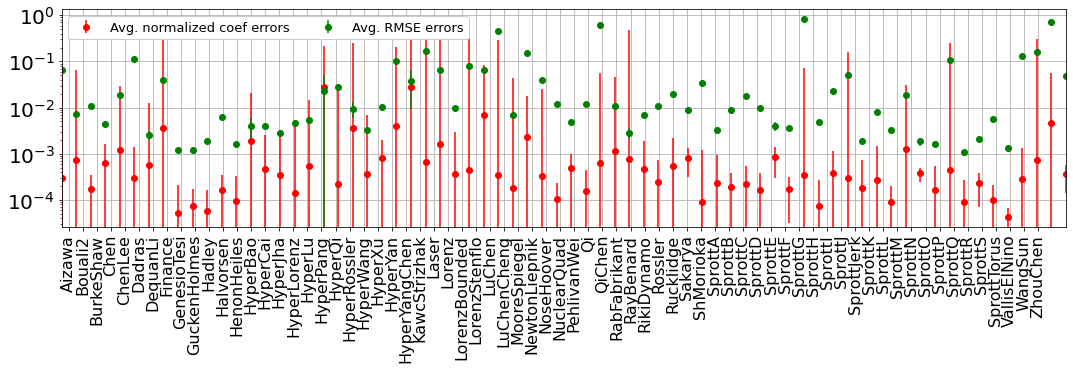

In [17]:
path='data/'
avg_rmse_error_STLSQ_AICwf_1 = np.loadtxt(path + 'avg_rmse_error_strong_STLSQ_AIC_weakform_noise1')
std_rmse_error_STLSQ_AICwf_1 = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC_weakform_noise1')
avg_coef_error_STLSQ_AICwf_1 = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC_weakform_noise1')
std_coef_error_STLSQ_AICwf_1 = np.loadtxt(path + 'std_coef_error_STLSQ_AIC_weakform_noise1')

plt.figure(figsize=(18, 4))
    
plt.errorbar(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    std_rmse_error_STLSQ_AICwf_1,
    std_coef_error_STLSQ_AICwf_1,
    fmt="ro",
    label="Avg. normalized coef errors",
)
plt.errorbar(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    avg_rmse_error_STLSQ_AICwf_1,
    std_rmse_error_STLSQ_AICwf_1,
    fmt="go",
    label="Avg. RMSE errors",
)
plt.grid(True)
plt.yscale("log")
plt.legend(
    framealpha=1.0,
    ncol=4,
    fontsize=13,
)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-0.5, num_attractors + 1)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(fontsize=20)
plt.show()

# Plot the true and predicted $\dot{\mathbf x}$ trajectories for all the chaotic systems
We find that the fits are very strong on the testing data, but the more stringent test (after this) will be to integrate new trajectories with new initial conditions, using our best SINDy models.

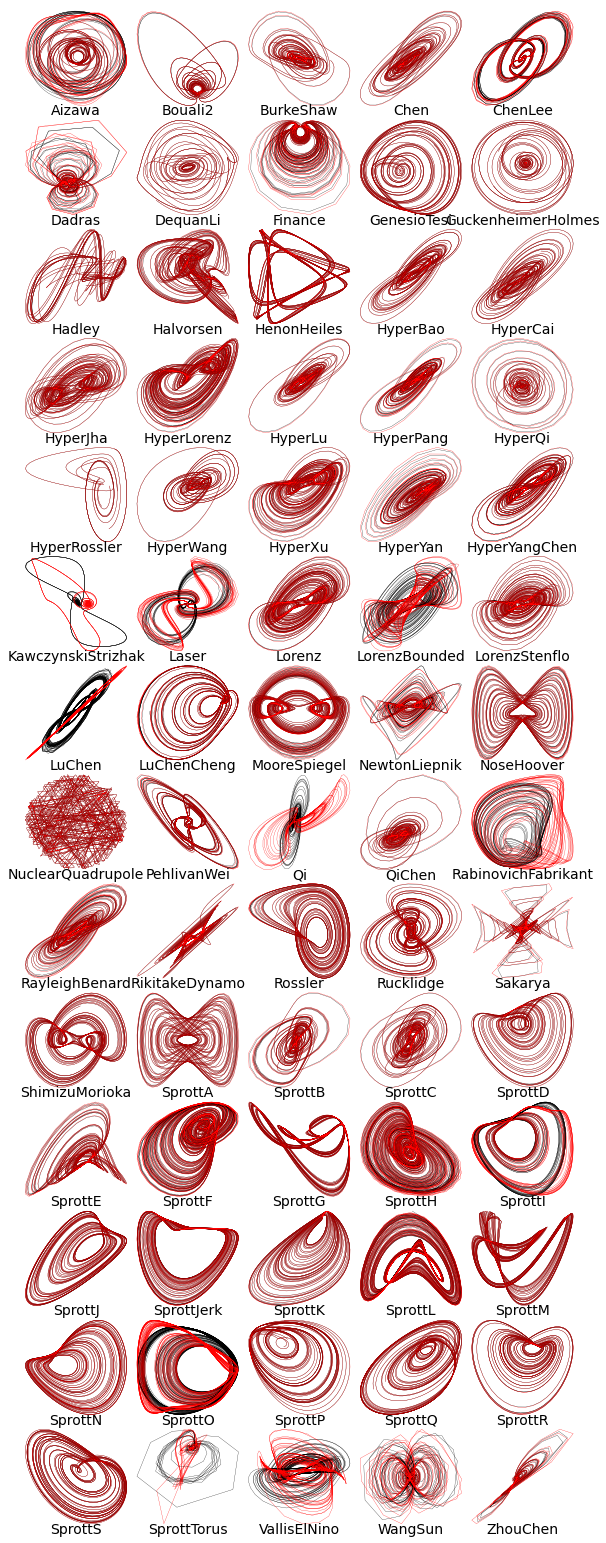

In [12]:
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

if weak_form and not strong_rmse:
    ntime = models[i].feature_library.K
else:
    ntime = len(all_t_train['Aizawa'][0])

for i, attractor_name in enumerate(systems_list):
    x_dot_test = np.array(x_dot_tests[i])
    x_dot_test_pred = np.array(x_dot_test_preds[i]).reshape(n_trajectories, ntime, dimension_list[i])
    plt.subplot(gs[i])
    for j in range(n_trajectories):
        plt.plot(x_dot_test[j, :, 0], x_dot_test[j, :, 1], 'k', linewidth=0.25)
        plt.plot(x_dot_test_pred[j, :, 0], x_dot_test_pred[j, :, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.1, fontsize=14)
    plt.gca().axis('off')
    

# Very stringent performance test for our best SINDy models
We will integrate new trajectories using 10 new initial conditions and see if the SINDy models reproduce the correct strange attractor(s) for each chaotic system in the database.

In [13]:
t1 = time.time()
num_test_trajectories = 10
test_trajectories, test_trajectories_time = make_test_trajectories(
    systems_list,
    all_properties,
    n=n,
    pts_per_period=pts_per_period,
    random_bump=False,  # pushes the initial condition to be slightly off the attractor
    include_transients=False,  # overwrites pts_per_period in order to sample at very high resolution
    n_trajectories=num_test_trajectories,
)

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
2 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
3 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
4 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
5 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
6 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
7 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
8 GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
9 GuckenheimerHolmes(name='GuckenheimerHolmes', params={'a': 0.4, 'b': 20.25, 'c': 3, 'd': 1.6, 'e': 1.7, 'f': 0.44}, random_

# Plot the trajectory results for 10 new initial conditions
Note that this is only sensible if we are not using the weak form, since the weak form functionality in the PySINDy code doesn't yet have functionality for integrating new trajectories.

In [14]:
if not weak_form:
    num_cols = 5
    num_rows = int(np.ceil(len(all_sols_train) / num_cols))
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
    gs.update(wspace=0.0, hspace=0.0) 

    for i, attractor in enumerate(systems_list):
        print(i, attractor)
        fig = plt.subplot(gs[i])
        num_bounded = num_test_trajectories
        for j in range(num_test_trajectories):
            plt.plot(test_trajectories[attractor][:, j, 0], test_trajectories[attractor][:, j, 1], 'k') #, test_trajectories[attractor][:, j, 2], 'k')
            x0 = test_trajectories[attractor][0, j, :] + (np.random.rand(dimension_list[i]) - 0.5) * np.linalg.norm(test_trajectories[attractor][:, j, :]) / 100.0
            models[i].feature_library.fit(np.zeros(dimension_list[i]))
            x_pred = models[i].simulate(
                x0, 
                t=test_trajectories_time[attractor][:, j],
                integrator='odeint'
            )
            if np.linalg.norm(x_pred) > np.linalg.norm(test_trajectories[attractor][:, j, 0]) * 10:
                num_bounded -= 1
            else:
                plt.plot(x_pred[:, 0], x_pred[:, 1], 'r')
            ax = plt.gca()
            fig.patch.set_facecolor('grey')
        fig.patch.set_alpha(1 - (num_bounded / num_test_trajectories))
        plt.yticks([])
        plt.xticks([])
        xmax = np.max(test_trajectories[attractor][:, :, 0])
        xmin = np.min(test_trajectories[attractor][:, :, 0])
        ymax = np.max(test_trajectories[attractor][:, :, 1])
        ymin = np.min(test_trajectories[attractor][:, :, 1])
        facx = (xmax - xmin) / 3
        facy = (ymax - ymin) / 3
        plt.xlim(xmin - facx, xmax + facx)
        plt.ylim(ymin - facy, ymax + facy)
        plt.text(0.035, 0.85, systems_list_cleaned[i], transform=ax.transAxes, fontsize=12)
        if i == 65:
            plt.xlabel(r'$x_1$', fontsize=18)
            plt.ylabel(r'$x_2$', fontsize=18, rotation=0, )
            ax.yaxis.set_label_coords(-0.15,0.45)
    plt.savefig('final_trajectories_zero_noise.pdf')
    t2 = time.time()
    print('Integrating all these new initial conditions took t = ', t2 - t1, ' seconds')